# Training a Unet for Image Segmentation

## Imports

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utils import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-10-11 10:58:27.779686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data

In [4]:
paths_df = pd.read_csv('People/paths.csv')
paths_df.head()

,image,mask
0,People/images/a-happy-woman-5321361__340.jpg,People/masks/a-happy-woman-5321361__340.png
1,People/images/a-man-3708963__340.jpg,People/masks/a-man-3708963__340.png
2,People/images/a-smile-2127788__340.jpg,People/masks/a-smile-2127788__340.png
3,People/images/abe-shinzo-867817__340.jpg,People/masks/abe-shinzo-867817__340.png
4,People/images/accessories-3557623__340.jpg,People/masks/accessories-3557623__340.png


In [5]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(paths_df, test_size=0.2, random_state=42)

In [6]:
from PIL import Image
import numpy as np

X_train, X_val, y_train, y_val = [], [], [], []

for img, msk in train_df.values:
    image = Image.open(f'/content/drive/MyDrive/Python/background_removal/{img}')
    mask = Image.open(f'/content/drive/MyDrive/Python/background_removal/{msk}')

    image = image.resize((256,256))
    image = np.array(image) / 255.0

    mask = mask.resize((256,256))
    mask = np.array(mask) / 255.0
    mask[mask>0] = 1.0
    mask = np.expand_dims(mask, axis=-1)
    if image.shape == (256, 256, 3):
        X_train.append(image)
        y_train.append(mask)


for img, msk in val_df.values:
    image = Image.open(f'/content/drive/MyDrive/Python/background_removal/{img}')
    mask = Image.open(f'/content/drive/MyDrive/Python/background_removal/{msk}')

    image = image.resize((256,256))
    image = np.array(image) / 255.0

    mask = mask.resize((256,256))
    mask = np.array(mask) / 255.0
    mask[mask>0] = 1.0
    mask = np.expand_dims(mask, axis=-1)
    if image.shape == (256, 256, 3):
        X_val.append(image)
        y_val.append(mask)


In [9]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape


((2643, 256, 256, 3),
 (660, 256, 256, 3),
 (2643, 256, 256, 1),
 (660, 256, 256, 1))

In [8]:
# np.save('X_train', X_train)
# np.save('X_val', X_val)
# np.save('y_train', y_train)
# np.save('y_val', y_val)
# 
# X_train = np.load('X_train.npy')
# X_val = np.load('X_val.npy')
# y_train = np.load('y_train.npy')
# y_val = np.load('y_val.npy')

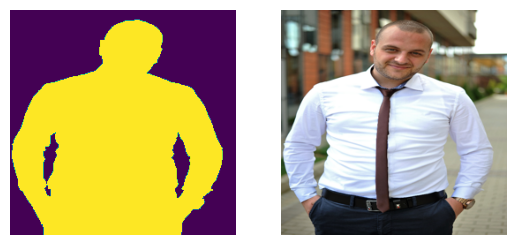

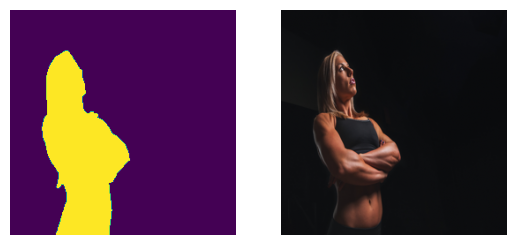

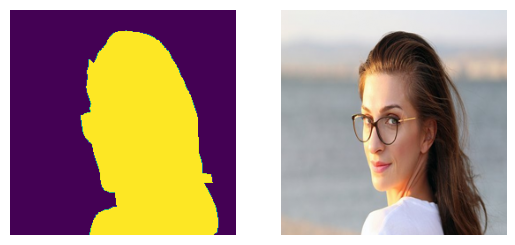

In [10]:
import random
n = random.sample(range(len(X_train)), 3)

for i in n:
    plt.subplot(121)
    plt.imshow(y_train[i])
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation in the range [-20, 20] degrees
    width_shift_range=0.1,  # Random horizontal shift by 10% of the width
    height_shift_range=0.1,  # Random vertical shift by 10% of the height
    zoom_range=0.1,  # Random zoom by 10%
    horizontal_flip=True,  # Random horizontal flip
)

mask_datagen = ImageDataGenerator(
    rotation_range=20,  # Same rotation as images
    width_shift_range=0.1,  # Same horizontal shift as images
    height_shift_range=0.1,  # Same vertical shift as images
    zoom_range=0.1,  # Same zoom as images
    horizontal_flip=True,  # Same horizontal flip as images
)

In [6]:
seed = 42
batch_size = 32

train_image = image_datagen.flow(X_train, seed=seed, batch_size=batch_size)
val_image = image_datagen.flow(X_val, seed=seed, batch_size=batch_size)

train_mask = mask_datagen.flow(y_train, seed=seed, batch_size=batch_size)
val_mask = mask_datagen.flow(y_val, seed=seed, batch_size=batch_size)


In [7]:
training_generator = zip(train_image, train_mask)
validation_generator = zip(val_image, val_mask)

del(X_train)
del(X_val)
del(y_train)
del(y_val)

## Model

The model is built using the functions defined in `utils.py`.

In [8]:
model = construct_unet(input_shape=(256,256,3))

## Training

Early stopping and a custom learning rate will be used for training the model.

In [9]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping


def custom_lr(epoch):
    n = 10
    r = 0.5
    lr_init = 0.0006
    lr = lr_init * r**(epoch//n)
    return lr

lr_scheduler = LearningRateScheduler(custom_lr)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0006),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [11]:
# Number of steps per epoch
train_steps_per_epoch = len(train_image)
val_steps_per_epoch = len(val_image)

# Number of epochs
epochs = 100

history = model.fit(training_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=val_steps_per_epoch,
                              callbacks=[lr_scheduler, early_stopping])


print(history.history)

Epoch 1/100
83/83 [==============================] - 281s 3s/step - loss: 0.6124 - accuracy: 0.6762 - val_loss: 0.5788 - val_accuracy: 0.7056 - lr: 6.0000e-04
Epoch 2/100
83/83 [==============================] - 181s 2s/step - loss: 0.5610 - accuracy: 0.7123 - val_loss: 0.5520 - val_accuracy: 0.7147 - lr: 6.0000e-04
Epoch 3/100
83/83 [==============================] - 181s 2s/step - loss: 0.5243 - accuracy: 0.7273 - val_loss: 0.5601 - val_accuracy: 0.7168 - lr: 6.0000e-04
Epoch 4/100
83/83 [==============================] - 178s 2s/step - loss: 0.4913 - accuracy: 0.7564 - val_loss: 0.4802 - val_accuracy: 0.7691 - lr: 6.0000e-04
Epoch 5/100
83/83 [==============================] - 181s 2s/step - loss: 0.4650 - accuracy: 0.7739 - val_loss: 0.5090 - val_accuracy: 0.7454 - lr: 6.0000e-04
Epoch 6/100
83/83 [==============================] - 178s 2s/step - loss: 0.4444 - accuracy: 0.7855 - val_loss: 0.4198 - val_accuracy: 0.8054 - lr: 6.0000e-04
Epoch 7/100
83/83 [===========================

## Results

The learning rate looks good as the model generalizes very well to the validation set. The final training accuracy and validation accuracy are almost the same and very high. 

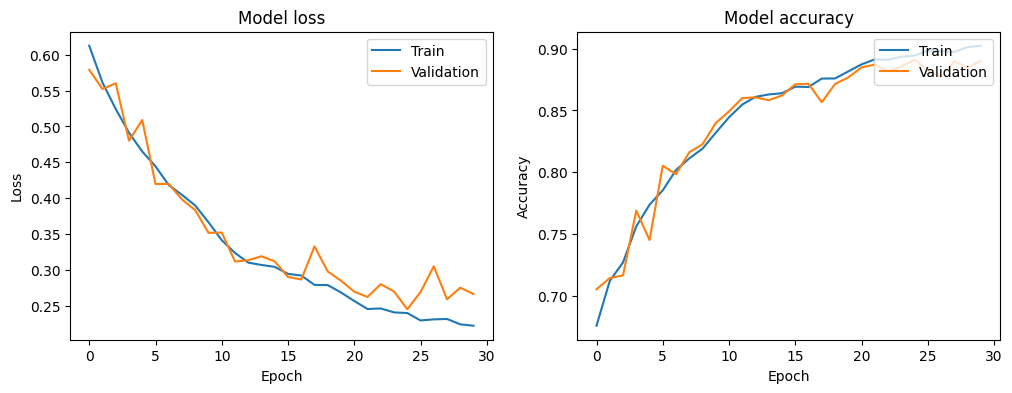

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('plots/training_curves.png')
plt.show()

In [17]:
model.save('/models/unet_model-256-v1.h5')

In [12]:
model = tf.keras.models.load_model('models/unet_model-256-v1.h5')

In [21]:
import random

# y_train = np.array(y_train)
# y_val = np.array(y_val)

preds = model.predict(X_val)
threshold_preds = preds > 0.5


21/21 [==============================] - 298s 14s/step


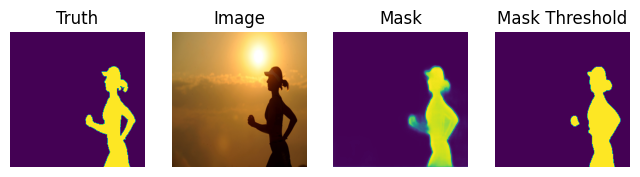

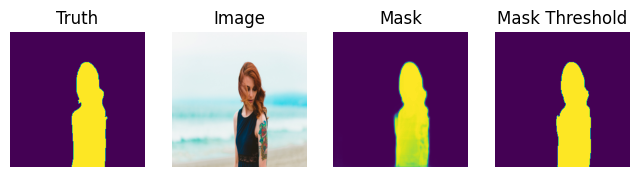

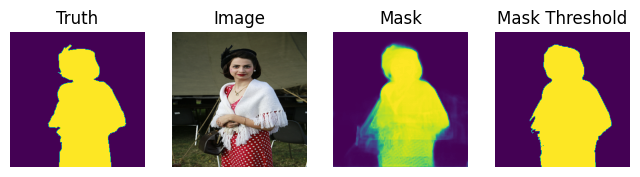

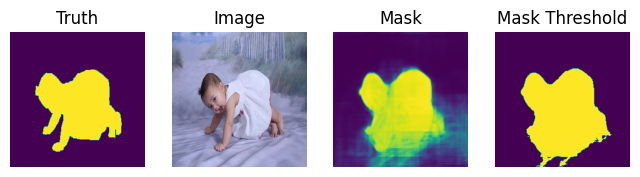

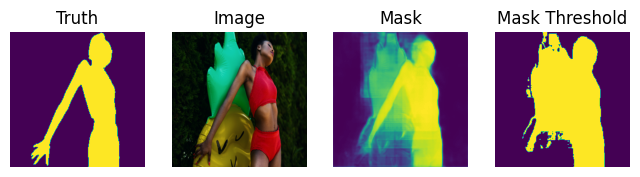

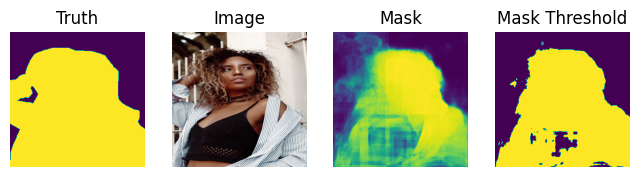

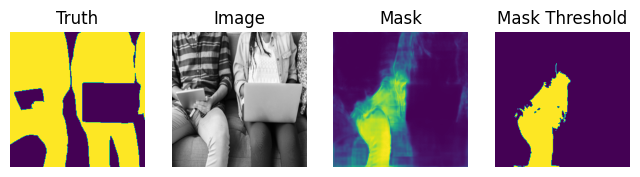

In [30]:
for i in random.sample(range(len(X_val)), 7):
    plt.figure(figsize=(8,5))
    plt.subplot(141)
    plt.title('Truth')
    plt.imshow(y_val[i])
    plt.axis('off')
    plt.subplot(142)
    plt.title('Image')
    plt.imshow(X_val[i])
    plt.axis('off')
    plt.subplot(143)
    plt.title('Mask')
    plt.imshow(preds[i])
    plt.axis('off')
    plt.subplot(144)
    plt.title('Mask Threshold')
    plt.imshow(threshold_preds[i])
    plt.axis('off')
    plt.show()